In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


## 1.1. Library Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.svm import SVC
import random
from scipy.stats import uniform, randint

# Suppress any warnings
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn import metrics

# kNN Imputation
from sklearn.impute import KNNImputer

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif

# Data Encoder and Scaler
import category_encoders as encoders
from sklearn.preprocessing import LabelEncoder, RobustScaler

# SMOTE (Synthetic Minority Over-sampling Technique)
from imblearn.over_sampling import SMOTE


## 1.2. Load the Data

In [3]:
# Read the train, test and greeks data

df_train = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
df_test = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")
df_greeks = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")

print('No. of records for train : {}'.format(df_train.shape))
print('No. of records for test : {}'.format(df_test.shape))
print('No. of records for greeks : {}'.format(df_greeks.shape))

No. of records for train : (617, 58)
No. of records for test : (5, 57)
No. of records for greeks : (617, 6)


# 2. EDA

# 2.1. Distribution of Target Label

Text(0.5, 1.0, 'Distribution of Target Label (i.e. Class)')

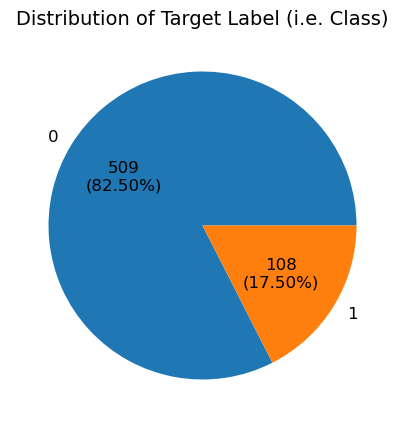

In [4]:
# check whether the data set is balanced

plt.figure(figsize=(5,5))

def auto_fmt (pct_value):
    return '{:.0f}\n({:.2f}%)'.format(df_train['Class'].value_counts().sum()*pct_value/100,pct_value) 

df_transported_count = df_train['Class'].value_counts().rename_axis('Class').reset_index(name='Counts')

fig = plt.gcf()
plt.pie(x=df_transported_count['Counts'], labels=df_transported_count['Class'], autopct=auto_fmt, textprops={'fontsize': 12})
plt.title('Distribution of Target Label (i.e. Class)',  fontsize = 14)

# 2.2. Missing Value Analysis

In [5]:
# Only include numerical features
df_train_numerical = df_train.drop(['Id', 'EJ', 'Class'], axis=1)

<Figure size 1000x600 with 0 Axes>

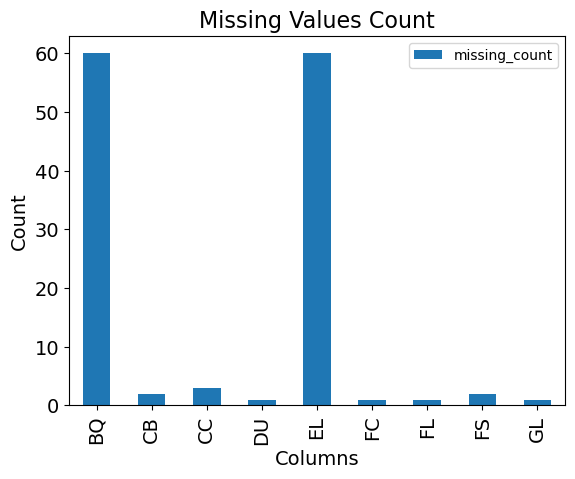

In [6]:

plt.figure(figsize=(10, 6))

# No. of missing values by features
df_train_missing = df_train_numerical.isna().sum()

# Resetting the index
df_train_missing = df_train_missing.reset_index()

# Renaming the columns
df_train_missing.columns = ['feature', 'missing_count']

# Filtering features with missing values
df_train_missing = df_train_missing.loc[df_train_missing['missing_count'] > 0]

# Create a bar chart
df_train_missing.plot.bar(x='feature', y='missing_count')

# Set the chart title and axis labels
plt.title('Missing Values Count', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)

# Display the chart
plt.show()



# 2.3. Descritpive Analysis

In [7]:
# Exclude the target label Class and categorical feature EJ in the Describe analysis
# Since there are too many colums for Describe analysis, we need to transpose the results. 

df_train_numerical.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
AB,617.0,0.477149,0.468388,0.081187,0.252107,0.354659,0.559763,6.161666
AF,617.0,3502.013221,2300.322717,192.593280,2197.345480,3120.318960,4361.637390,28688.187660
AH,617.0,118.624513,127.838950,85.200147,85.200147,85.200147,113.739540,1910.123198
AM,617.0,38.968552,69.728226,3.177522,12.270314,20.533110,39.139886,630.518230
AR,617.0,10.128242,10.518877,8.138688,8.138688,8.138688,8.138688,178.943634
AX,617.0,5.545576,2.551696,0.699861,4.128294,5.031912,6.431634,38.270880
AY,617.0,0.060320,0.416817,0.025578,0.025578,0.025578,0.036845,10.315851
AZ,617.0,10.566447,4.350645,3.396778,8.129580,10.461320,12.969516,38.971568
BC,617.0,8.053012,65.166943,1.229900,1.229900,1.229900,5.081244,1463.693448
BD,617.0,5350.388655,3021.326641,1693.624320,4155.702870,4997.960730,6035.885700,53060.599240


# 2.4. Histogram Analysis for Skewness

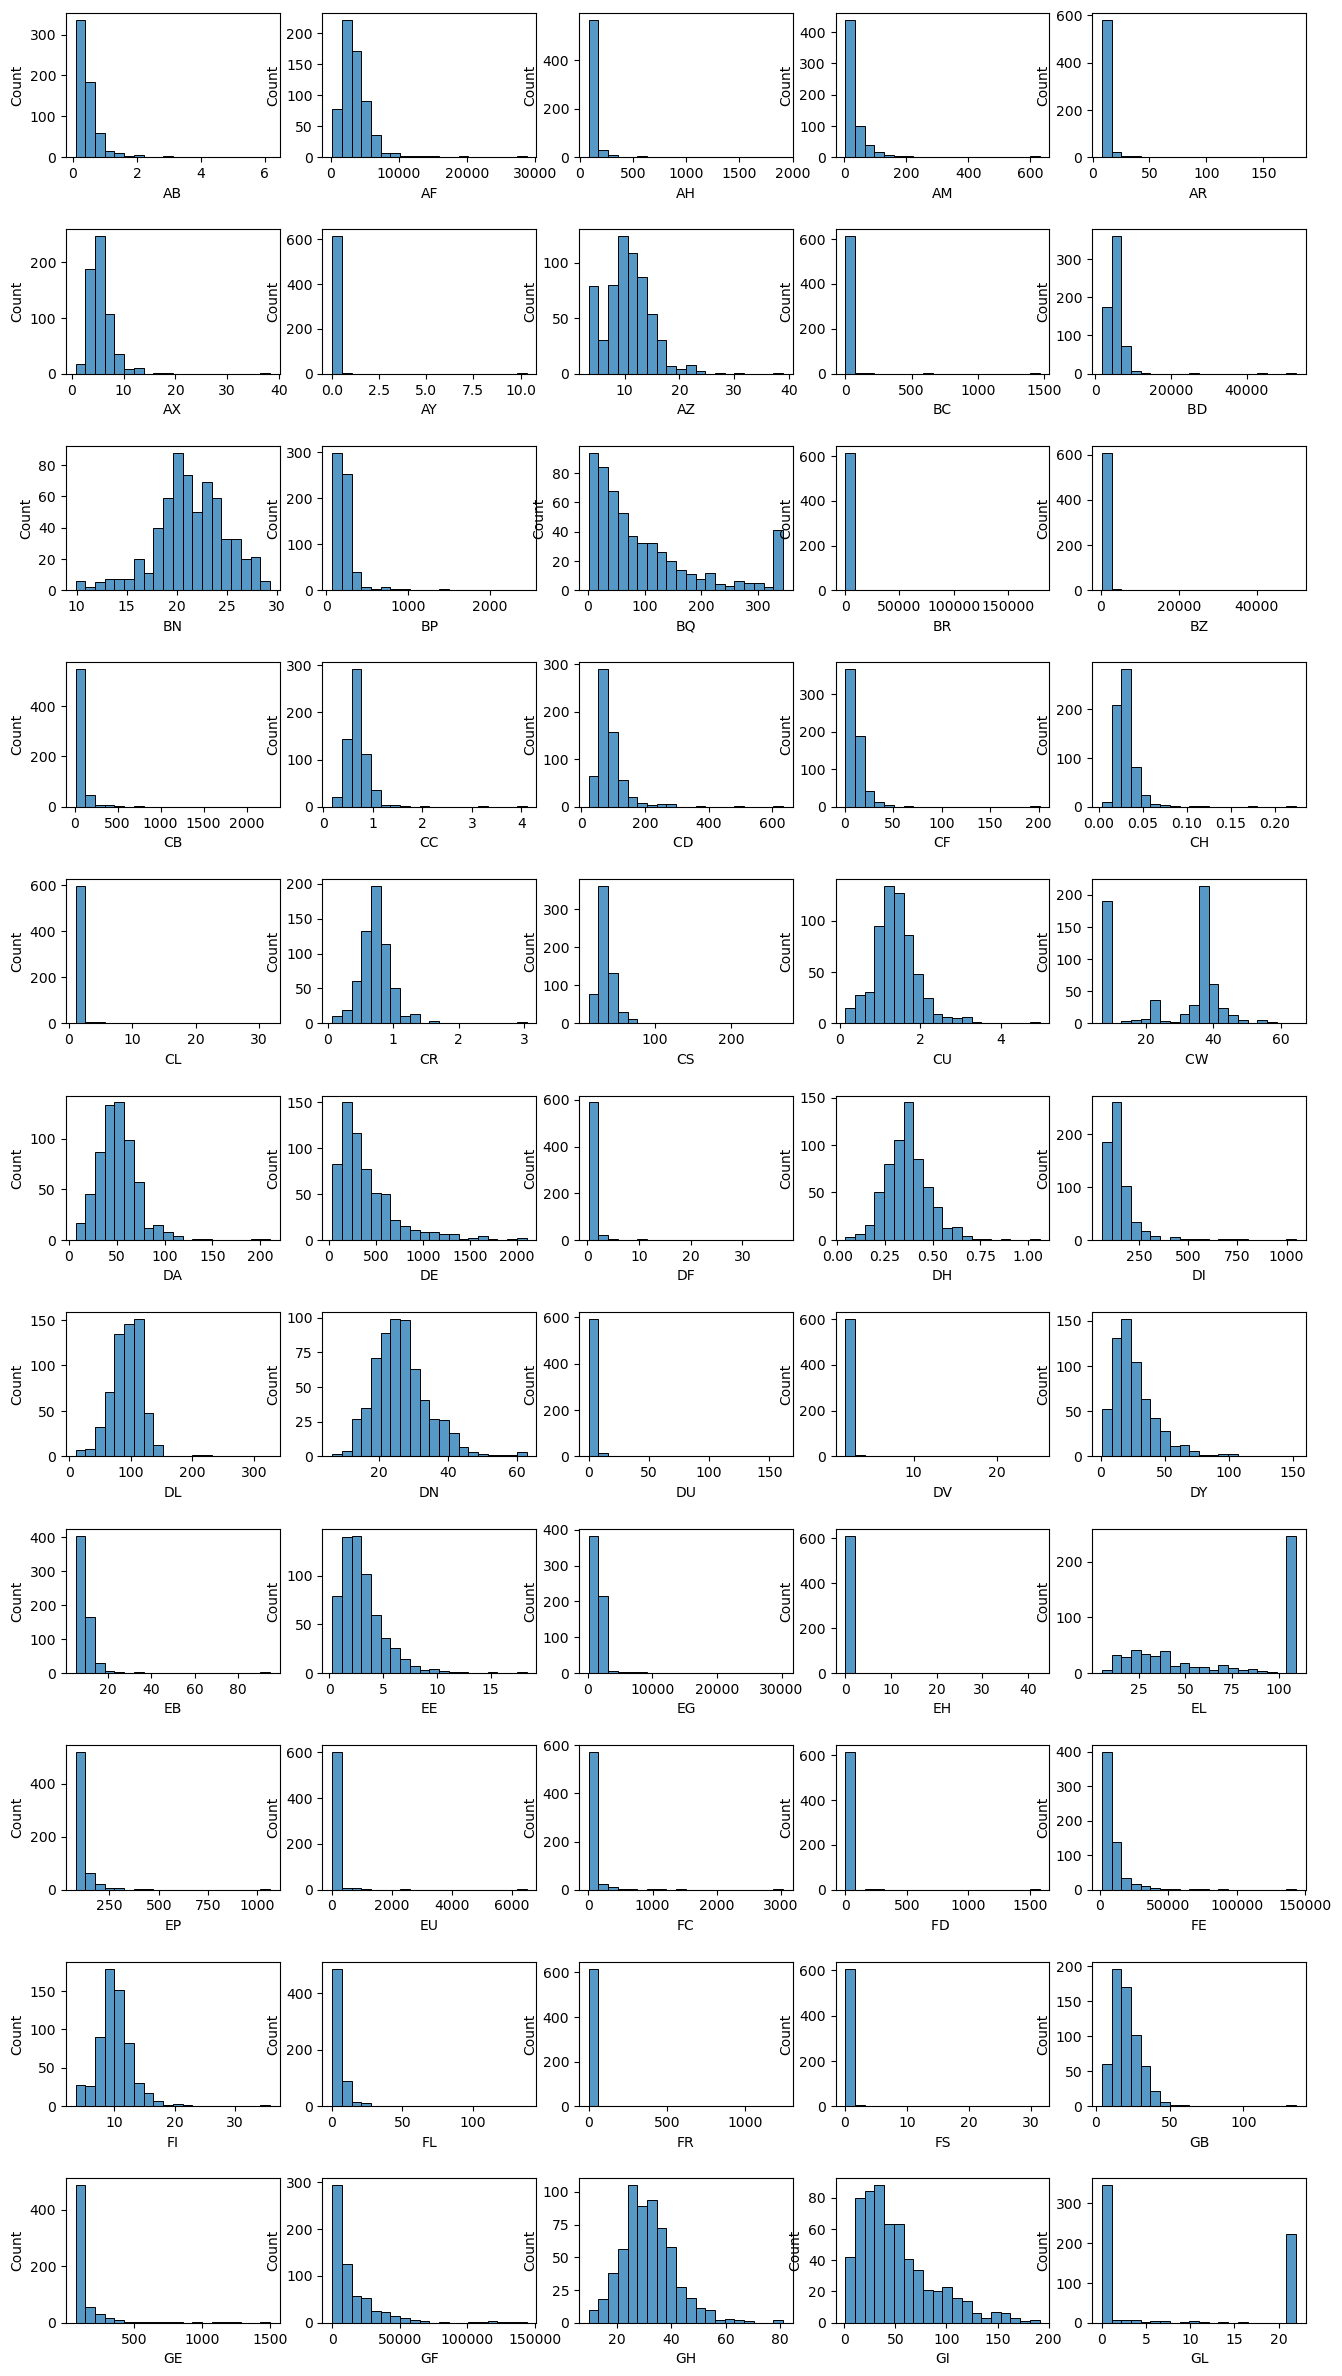

In [8]:
# Histgram for numercial features
fig, ax = plt.subplots(11, 5, figsize=(16,30))

for i in range(0, (len(ax.flatten()))):
#     print('{}, {}'.format(int(i/5),i % 5))
    sns.histplot(data=df_train_numerical, x =df_train_numerical.iloc[:,i], bins=20, ax=ax[int(i/5),i % 5])
#     ax[int(i/5), i % 5].set_title(df_train_numerical.columns[i])

# Adjust the vertical spacing between subplots    
plt.subplots_adjust(hspace=0.5)  

plt.show()

# 2.5. Boxplot Analysis for Outliers

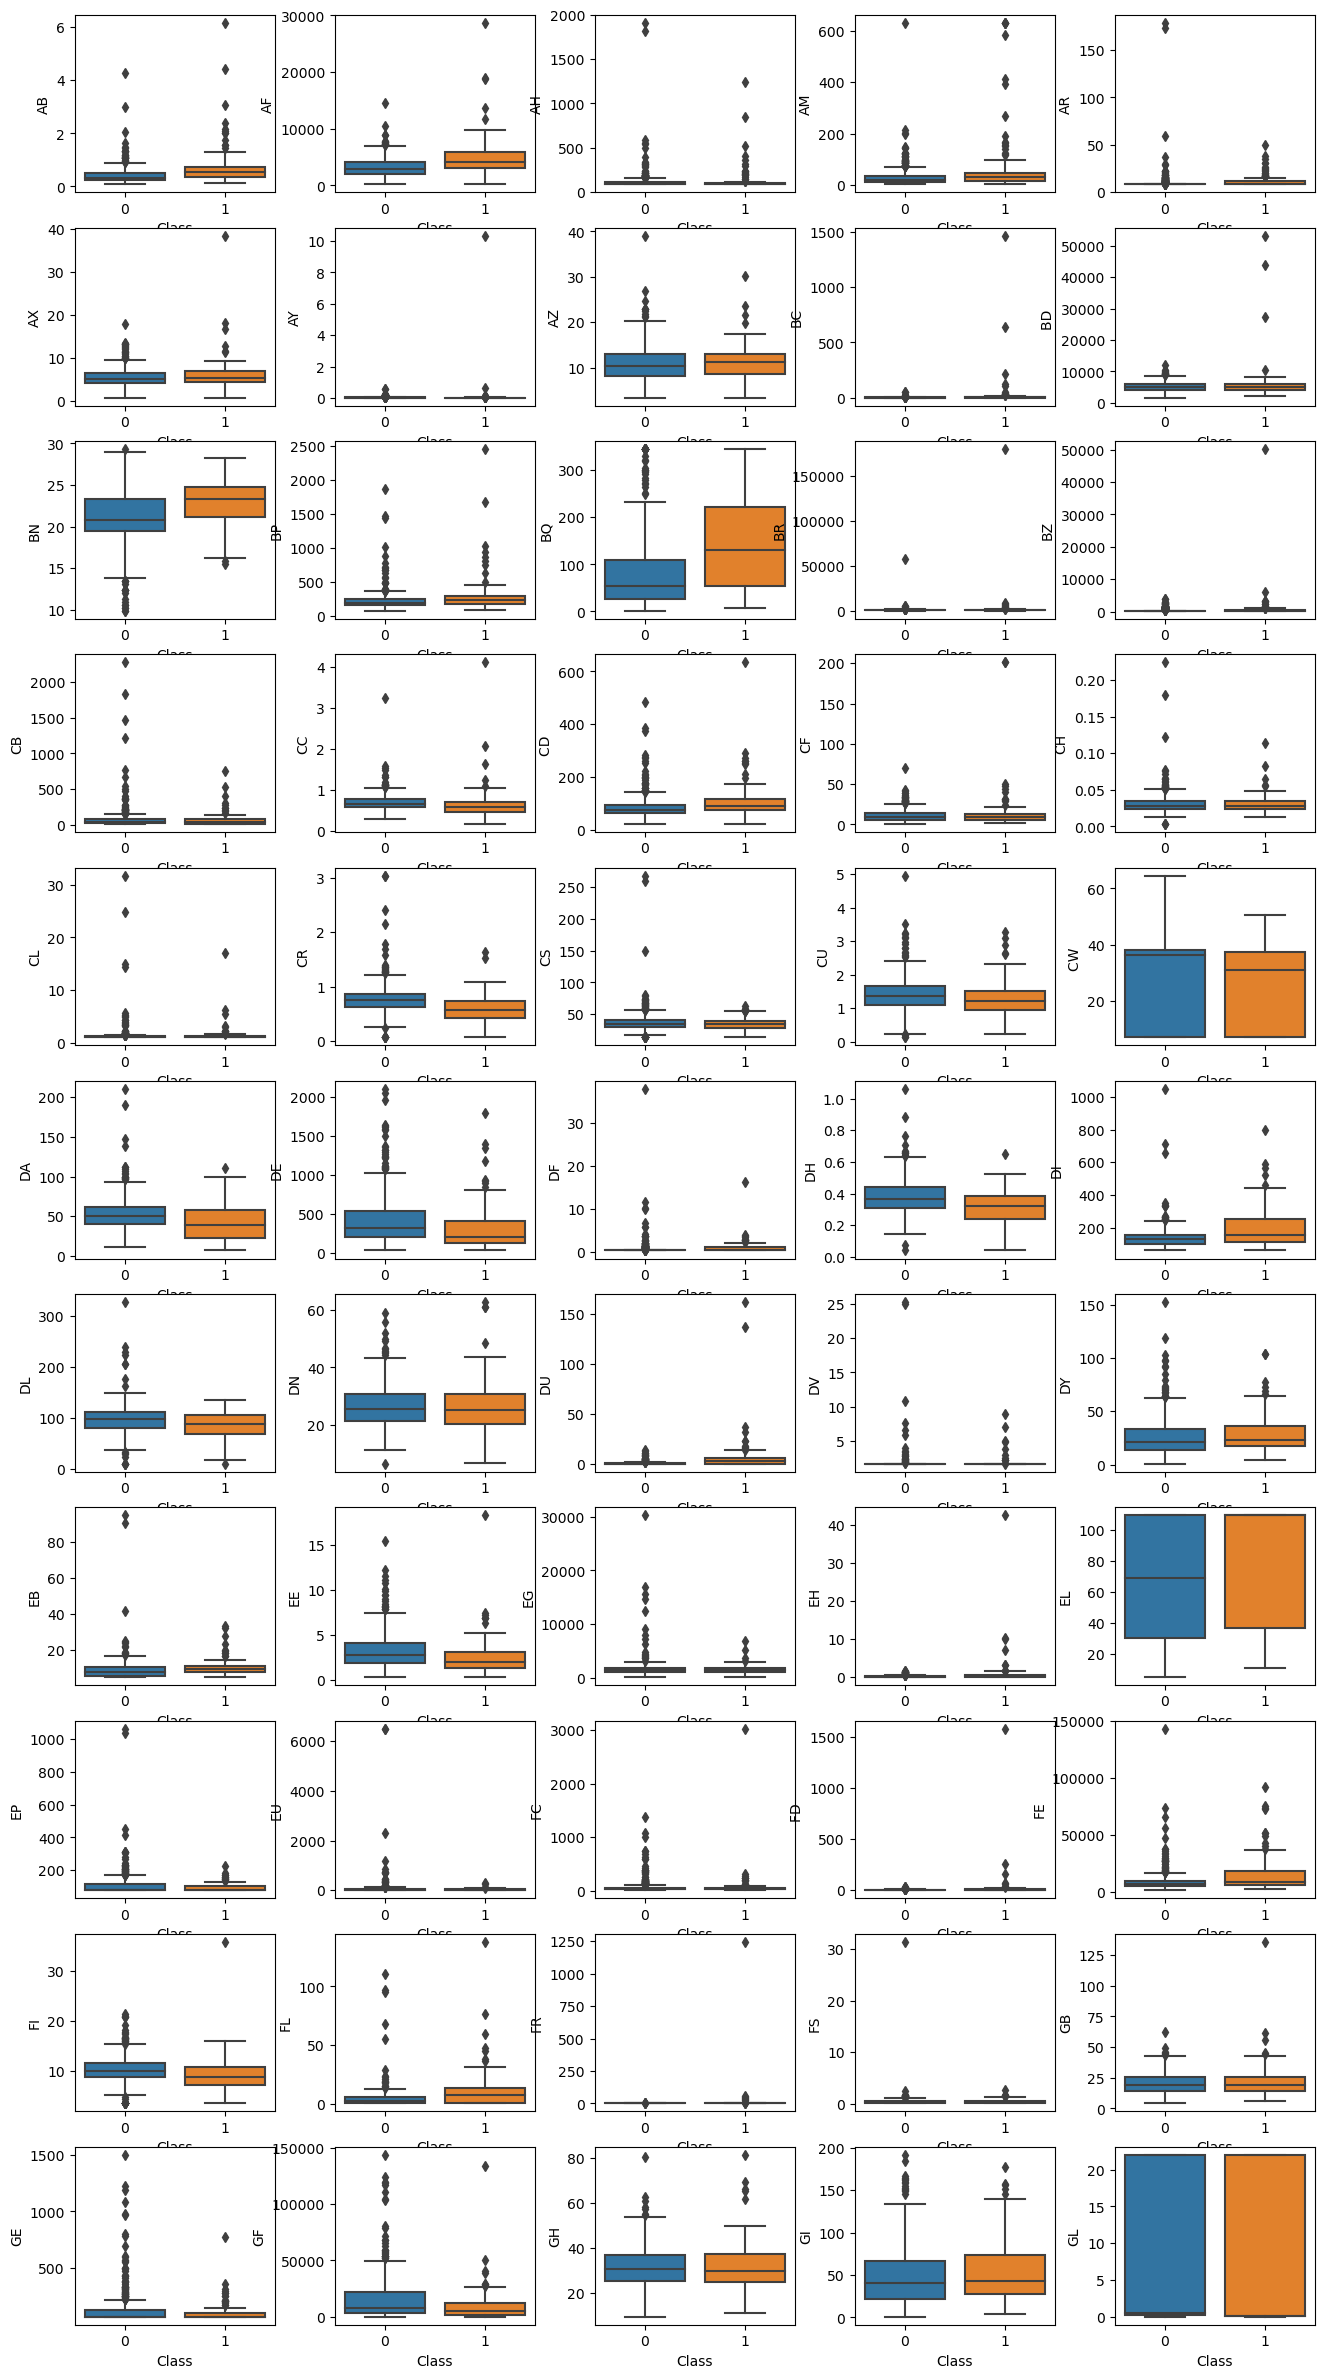

In [9]:
# Histgram for numercial features
fig, ax = plt.subplots(11, 5, figsize=(16,30))

for i in range(0, (len(ax.flatten()))):
    sns.boxplot(x="Class",y=df_train_numerical.columns[i],data=df_train, ax=ax[int(i/5),i % 5])

# Adjust the vertical spacing between subplots    
plt.subplots_adjust(wspace=0.3)  

plt.show()

# 2.6. Count Plot for Distribution of Categorical Features

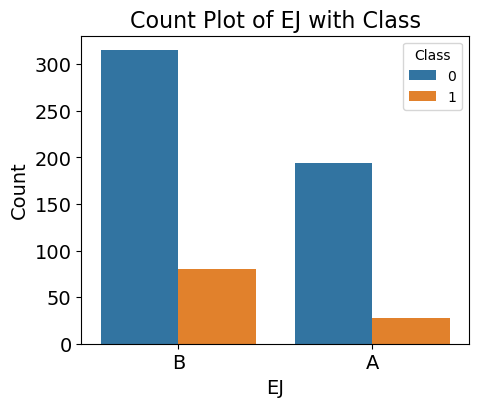

In [10]:
# Set the size of the chart
plt.figure(figsize=(5, 4))
plt.legend(fontsize=13)

# Create the count plot
sns.countplot(data=df_train, x='EJ', hue='Class')

# Set the labels and title
plt.xlabel('EJ', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count Plot of EJ with Class', fontsize=16)

# Adjust the tick label size
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)

# Add a legend
plt.legend(title='Class')

plt.show()

# 3. Data Pre-processing for Model Data

# 3.1. Missing Value Imputation - kNN Imputer


In [11]:
# Initialize the KNNImputer with the desired number of neighbors
imputer = KNNImputer(n_neighbors=5)

# Perform KNN imputation
df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train[df_train_numerical.columns]), columns=df_train_numerical.columns)
df_test_imputed =pd.DataFrame(imputer.transform(df_test[df_train_numerical.columns]), columns=df_train_numerical.columns)


In [12]:
# Check if there are still missing values in the train and test data sets
df_train_null = df_train_imputed[df_train_imputed.isnull().any(axis=1)]
df_test_null = df_test_imputed[df_test_imputed.isnull().any(axis=1)]

# Display the rows with null values
print('No. of records with missing value in Train data set after Imputation : {}'.format(df_train_null.shape[0]))
print('No. of records with missing value in Test data set after Imputation : {}'.format(df_test_null.shape[0]))

# Check the shape of the train and test data set 
print('=' * 50)
print('Shape of the Train data set : {}'.format(df_train_imputed.shape))
print('Shape of the Test data set : {}'.format(df_test_imputed.shape))

No. of records with missing value in Train data set after Imputation : 0
No. of records with missing value in Test data set after Imputation : 0
Shape of the Train data set : (617, 55)
Shape of the Test data set : (5, 55)


In [13]:
# Replace the imputed columns in the train data sets
df_train_2 = df_train.drop(df_train_numerical.columns, axis=1)
df_train_2 = pd.concat ([df_train_2, df_train_imputed], axis=1)

# Replace the imputed columns in the test data sets
df_test_2 = df_test.drop(df_train_numerical.columns, axis=1)
df_test_2 = pd.concat ([df_test_2, df_test_imputed], axis=1)

# Check the shape of the train and test data set 
print('Shape of the Train data set : {}'.format(df_train_2.shape))
print('Shape of the Test data set : {}'.format(df_test_2.shape))


Shape of the Train data set : (617, 58)
Shape of the Test data set : (5, 57)


# 3.2. Data Standarization for Numercial Features

In [14]:
# Create a RobustScaler object
scaler = RobustScaler()

# Extract the index
index = df_train_2.index

# Fit the scaler to the data and transform it
scaler_train = scaler.fit_transform(df_train_2[df_train_numerical.columns])
scaler_df_train = pd.DataFrame(scaler_train, columns=df_train_numerical.columns)

# Reassign the index to the scaled DataFrame
scaler_df_train.index = index
print('Shape of Scaled Train Data Set: {}'.format(scaler_df_train.shape))


# Extract the index
index = df_test_2.index

scaler_test = scaler.transform(df_test_2[df_train_numerical.columns])
scaler_df_test = pd.DataFrame(scaler_test, columns=df_train_numerical.columns)

# Reassign the index to the scaled DataFrame
scaler_df_test.index = index
print('Shape of Scaled Test Data Set: {}'.format(scaler_df_test.shape))


Shape of Scaled Train Data Set: (617, 55)
Shape of Scaled Test Data Set: (5, 55)


In [15]:
# Replace the scaled columns in the train data sets
df_train_2 = df_train_2.drop(df_train_numerical.columns, axis=1)
df_train_2 = pd.concat ([df_train_2, scaler_df_train], axis=1)

# Replace the imputed columns in the test data sets
df_test_2 = df_test_2.drop(df_train_numerical.columns, axis=1)
df_test_2 = pd.concat ([df_test_2, scaler_df_test], axis=1)

# Check the shape of the train and test data set 
print('Shape of the Train data set : {}'.format(df_train_2.shape))
print('Shape of the Test data set : {}'.format(df_test_2.shape))


Shape of the Train data set : (617, 58)
Shape of the Test data set : (5, 57)


# 3.3. Data Encoding for Categorical Features

In [16]:
# Load the CatBoost Encoder 
CATBoostENCODE = encoders.CatBoostEncoder()

categorical_cols = ['EJ']

# Use CatBoost to encode the categorical values
encoder_train = CATBoostENCODE.fit_transform(df_train[categorical_cols], df_train['Class'])
encoded_df_train = pd.DataFrame(encoder_train)
print('Shape of the Encoded Train Data Set: {}'.format(encoded_df_train.shape))

encoder_test = CATBoostENCODE.transform(df_test[categorical_cols])
encoded_df_test = pd.DataFrame(encoder_test)
print('Shape of the Encoded Test Data Set: {}'.format(encoded_df_test.shape))

Shape of the Encoded Train Data Set: (617, 1)
Shape of the Encoded Test Data Set: (5, 1)


In [17]:
# Replace the encoded columns in the train data sets
df_train_2 = df_train_2.drop(categorical_cols, axis=1)
df_train_2 = pd.concat ([df_train_2, encoded_df_train], axis=1)

# Replace the imputed columns in the test data sets
df_test_2 = df_test_2.drop(categorical_cols, axis=1)
df_test_2 = pd.concat ([df_test_2, encoded_df_test], axis=1)

# Check the shape of the train and test data set 
print('Shape of the Train data set : {}'.format(df_train_2.shape))
print('Shape of the Test data set : {}'.format(df_test_2.shape))

Shape of the Train data set : (617, 58)
Shape of the Test data set : (5, 57)


# 3.4. SelectKBest Method from SKLearn for Feature Selection

In [18]:
# Before we do the oversampling, we will split the data into training and testing data for model training
train = df_train_2.drop(['Id', 'Class'], axis=1)
test = df_train_2['Class']

# Renaming the columns
test.columns = ['Class']


In [19]:
threshold = 0.05
t_score = 5

# Initiate the SelectKBest function
# For regression tasks: f_regression, mutual_info_regression
# For classification tasks: chi2, f_classif, mutual_info_classif
fs = SelectKBest(score_func=f_classif, k=len(train.columns))

# apply feature selection
X_selected = fs.fit_transform(train, test.values)
print('Before the SelectKBest = {}'.format(train.shape))

new_features = [] # The list of features less than the p-values
drop_features = [] # The list of features higher than the p-values

for i in range(len(train.columns)):
    print('Feature {}: {:.3f} with p-value {:.3f}'.format(train.columns[i], fs.scores_[i], fs.pvalues_[i]))
    if fs.pvalues_[i] <= threshold and fs.scores_[i] >= t_score:
        new_features.append(train.columns[i])
    else:
        drop_features.append(train.columns[i])

X_selected_final =  pd.DataFrame(X_selected)
X_selected_final.columns = train.columns
#    print(X_selected_final.shape)
X_selected_final = X_selected_final[new_features]
#    print(X_selected_final.shape)

print('=' * 30)
print('After the SelectKBest = {}'.format(X_selected_final.shape))
print('Drop-out Features = {}'.format(len(drop_features)))


Before the SelectKBest = (617, 56)
Feature AB: 52.566 with p-value 0.000
Feature AF: 62.007 with p-value 0.000
Feature AH: 1.228 with p-value 0.268
Feature AM: 37.314 with p-value 0.000
Feature AR: 2.560 with p-value 0.110
Feature AX: 5.917 with p-value 0.015
Feature AY: 4.206 with p-value 0.041
Feature AZ: 0.112 with p-value 0.738
Feature BC: 15.316 with p-value 0.000
Feature BD : 7.839 with p-value 0.005
Feature BN: 25.169 with p-value 0.000
Feature BP: 15.600 with p-value 0.000
Feature BQ: 50.639 with p-value 0.000
Feature BR: 4.861 with p-value 0.028
Feature BZ: 7.872 with p-value 0.005
Feature CB: 0.131 with p-value 0.717
Feature CC: 1.517 with p-value 0.219
Feature CD : 18.593 with p-value 0.000
Feature CF: 7.498 with p-value 0.006
Feature CH: 0.041 with p-value 0.840
Feature CL: 0.175 with p-value 0.676
Feature CR: 33.582 with p-value 0.000
Feature CS: 1.387 with p-value 0.239
Feature CU: 4.285 with p-value 0.039
Feature CW : 2.423 with p-value 0.120
Feature DA: 26.873 with p-va

In [20]:
# Drop out low informative features for model training 
train = train.drop(drop_features, axis=1)
df_train_2  = df_train_2.drop(drop_features, axis=1)
df_test_2  = df_test_2.drop(drop_features, axis=1)


# 3.5. Oversampling with SMOTE (Synthetic Minority Over-sampling Technique)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.3)

print('Shape of train : {}'.format(X_train.shape))
print('Shape of test : {}'.format(X_test.shape))
print('='*50)
print('Shape of df_train (incl. ID and Class): {}'.format(df_train_2.shape))
print('Shape of df_test (incl. ID): {}'.format(df_test_2.shape))

Shape of train : (431, 28)
Shape of test : (186, 28)
Shape of df_train (incl. ID and Class): (617, 30)
Shape of df_test (incl. ID): (5, 29)


In [22]:
# Load the SMOTE library 
smote = SMOTE(sampling_strategy={0: 360, 1: 360})
# df_train_numerical = df_train.drop(['Id', 'EJ', 'Class'], axis=1)

X_smote, y_smote = smote.fit_resample(X_train, y_train)
print("length of original data is ",len(df_train_2))
print("Proportion of True data in original data is {:.2%}".format(len(y_train[y_train==1])/len(y_train)))
print("Proportion of False data in original data is {:.2%}".format(len(y_train[y_train==0])/len(y_train)))
print("length of oversampled data is ",len(X_smote))
print("Proportion of True data in oversampled data is {:.2%}".format(len(y_smote[y_smote ==1])/len(y_smote)))
print("Proportion of False data in oversampled data is {:.2%}".format(len(y_smote[y_smote ==0])/len(y_smote)))
   


length of original data is  617
Proportion of True data in original data is 16.71%
Proportion of False data in original data is 83.29%
length of oversampled data is  720
Proportion of True data in oversampled data is 50.00%
Proportion of False data in oversampled data is 50.00%


# 4. Modelling

In [23]:
# Parameter Setup
p_folds = 5
p_iter = 100
p_estimators = 100
p_learning_rate = 0.01

# 4.1. XGBoost

In [24]:
# A parameter grid for XGBoost
params = {
        'max_depth': randint(5, 10),
        'gamma': uniform(0.0, 0.5),
        'subsample': uniform(0.6, 1.0),
        'colsample_bytree': uniform(0.6, 1.0),
        'reg_alpha': uniform(0.0, 1.0),
        'reg_lambda': uniform(0.0, 1.0),
        'min_child_weight': randint(3, 6),
        'scale_pos_weight': randint(1, 5)     
        }

In [25]:
xgb = XGBClassifier(learning_rate=p_learning_rate, n_estimators = p_estimators, objective='binary:logistic')

In [26]:
folds = p_folds

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 0)

xg_model = RandomizedSearchCV(xgb, param_distributions=params, n_iter=p_iter, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_smote,y_smote), verbose=-1, random_state=0 )

xg_model.fit(X_smote, y_smote)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7aebae532dc0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type...
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7aebae542ad0>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7aebae542e90>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7aebae542800>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7aebb52d2b60>},
                   random_state=0, scoring='roc_auc', verbose=-1)

In [27]:
print(xg_model.best_estimator_)
print(xg_model.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6902329794896908, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.30959139980778816, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)
{'colsample_bytree': 0.6902329794896908, 'gamma': 0.30959139980778816, 'max_depth': 8, 'min_child_weight': 3, 'reg_alpha': 0.16902540612916128, 'reg_lambda': 0.8595808364196215, 'scale_pos_weight': 2, 'subsample': 0.871113391

In [28]:
# Retrieve the best estimator and build the optimal model for analysis of Global Importance
best_xgb =XGBClassifier(**xg_model.best_estimator_.get_params())
best_xgb.fit(X_smote,y_smote)
accuracy = best_xgb.score(X_test, y_test)
print('Accuracy of XGBoost : {}'.format(accuracy))

Accuracy of XGBoost : 0.8494623655913979


# 4.2. LGBM

In [29]:
# params = {
# #     'learning_rate': [0.01, 0.05, 0.1],
# #     'n_estimators': [50, 100, 500, 1000],
#     'num_leaves': randint(5, 50),
#     'max_depth': randint(5, 10)
# }

# lgbm = LGBMClassifier(random_state=0, n_estimators=p_estimators, learning_rate = p_learning_rate)

In [30]:
# folds = p_folds

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 0)

# lgbm_model = RandomizedSearchCV(lgbm, param_distributions=params, n_iter=p_iter, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_smote,y_smote), verbose=-1, random_state=0 )

# lgbm_model.fit(X_smote, y_smote)

In [31]:
# print(lgbm_model.best_estimator_)
# print(lgbm_model.best_params_)

In [32]:
# # Retrieve the best estimator and build the optimal model for analysis of Global Importance

# best_lgbm =LGBMClassifier(**lgbm_model.best_estimator_.get_params())
# best_lgbm.fit(X_smote,y_smote)
# accuracy = best_lgbm.score(X_test, y_test)
# print('Accuracy of LGBM : {}'.format(accuracy))


# 4.3. Logistic Regression

In [33]:
# Specify the hyperparameter grid

params = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],   
    'max_iter': [100, 200, 300],
    'tol': [0.001, 0.01]
}

# Define the logistic regression model
logreg = LogisticRegression()

In [34]:
folds = p_folds

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 0)

logreg_model = RandomizedSearchCV(logreg, param_distributions=params, n_iter=p_iter, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_smote,y_smote), verbose=-1, random_state=0 )

logreg_model.fit(X_smote, y_smote)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7aebae533300>,
                   estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10],
                                        'max_iter': [100, 200, 300],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga'],
                                        'tol': [0.001, 0.01]},
                   random_state=0, scoring='roc_auc', verbose=-1)

In [35]:
print(logreg_model.best_estimator_)
print(logreg_model.best_params_)

LogisticRegression(C=1, max_iter=200, penalty='l1', solver='liblinear',
                   tol=0.001)
{'tol': 0.001, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 200, 'C': 1}


In [36]:
# Retrieve the best estimator and build the optimal model for analysis of Global Importance

best_logreg =LogisticRegression(**logreg_model.best_estimator_.get_params())
best_logreg.fit(X_smote,y_smote)
accuracy = best_logreg.score(X_test, y_test)

print('Accuracy of Logistic Regression : {}'.format(accuracy))

Accuracy of Logistic Regression : 0.8709677419354839


# 4.4 CatBoost

In [37]:
from scipy.stats import randint, uniform

params = {
    'max_depth': randint(5, 10),
    'learning_rate': uniform(0.01, 0.2),
    #'l2_leaf_reg': uniform(0.0, 1.0),
    'subsample': uniform(0.6, 1.0),
    'colsample_bylevel': uniform(0.6, 1.0),
    'reg_lambda': uniform(0.0, 1.0),
    'min_child_samples': randint(3, 7),
    #'scale_pos_weight': randint(1, 10)
}

In [38]:
cat = CatBoostClassifier(learning_rate=p_learning_rate, n_estimators = p_estimators) #objective='binary:logistic')

In [39]:
folds = p_folds

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 0)

cat_model = RandomizedSearchCV(cat, param_distributions=params, n_iter=p_iter, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_smote,y_smote), verbose=-1, random_state=0 )

cat_model.fit(X_smote, y_smote)

0:	learn: 0.6114838	total: 61.2ms	remaining: 6.06s
1:	learn: 0.5302713	total: 68.3ms	remaining: 3.35s
2:	learn: 0.4554629	total: 74.7ms	remaining: 2.42s
3:	learn: 0.4108917	total: 80ms	remaining: 1.92s
4:	learn: 0.3583737	total: 85.8ms	remaining: 1.63s
5:	learn: 0.3152384	total: 96.4ms	remaining: 1.51s
6:	learn: 0.2800978	total: 117ms	remaining: 1.55s
7:	learn: 0.2542133	total: 130ms	remaining: 1.49s
8:	learn: 0.2269379	total: 136ms	remaining: 1.37s
9:	learn: 0.2098951	total: 151ms	remaining: 1.35s
10:	learn: 0.1951433	total: 163ms	remaining: 1.32s
11:	learn: 0.1789849	total: 176ms	remaining: 1.29s
12:	learn: 0.1637684	total: 188ms	remaining: 1.26s
13:	learn: 0.1467289	total: 207ms	remaining: 1.27s
14:	learn: 0.1348671	total: 219ms	remaining: 1.24s
15:	learn: 0.1246591	total: 234ms	remaining: 1.23s
16:	learn: 0.1192400	total: 246ms	remaining: 1.2s
17:	learn: 0.1126630	total: 262ms	remaining: 1.19s
18:	learn: 0.1079405	total: 274ms	remaining: 1.17s
19:	learn: 0.1033777	total: 287ms	rema

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7aebae533840>,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7aebadc82f80>,
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bylevel': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7aebadc83f70>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_froze...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7aebae6e27a0>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7aebadc81cf0>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7aebadc83070>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7aebadc82e60>},
                   random_state=0, scoring='roc_auc', verbose=-1)

In [40]:
print(cat_model.best_estimator_)
print(cat_model.best_params_)

{'colsample_bylevel': 0.7861930058803361, 'learning_rate': 0.19887447799678673, 'max_depth': 7, 'min_child_samples': 6, 'reg_lambda': 0.22741462797332324, 'subsample': 0.8543564817703929}


In [41]:
# Retrieve the best estimator and build the optimal model for analysis of Global Importance
best_cat =CatBoostClassifier(**cat_model.best_estimator_.get_params())
best_cat.fit(X_smote,y_smote)
accuracy = best_cat.score(X_test, y_test)
print('Accuracy of CatBoost : {}'.format(accuracy))

0:	learn: 0.4474906	total: 13.7ms	remaining: 1.36s
1:	learn: 0.3293258	total: 25.7ms	remaining: 1.26s
2:	learn: 0.2402098	total: 37.4ms	remaining: 1.21s
3:	learn: 0.1909144	total: 48.5ms	remaining: 1.16s
4:	learn: 0.1491983	total: 59.4ms	remaining: 1.13s
5:	learn: 0.1232462	total: 75.2ms	remaining: 1.18s
6:	learn: 0.0921550	total: 90ms	remaining: 1.2s
7:	learn: 0.0771239	total: 102ms	remaining: 1.17s
8:	learn: 0.0644940	total: 114ms	remaining: 1.15s
9:	learn: 0.0565033	total: 125ms	remaining: 1.12s
10:	learn: 0.0478022	total: 136ms	remaining: 1.1s
11:	learn: 0.0395264	total: 149ms	remaining: 1.09s
12:	learn: 0.0335468	total: 160ms	remaining: 1.07s
13:	learn: 0.0287982	total: 171ms	remaining: 1.05s
14:	learn: 0.0252125	total: 183ms	remaining: 1.04s
15:	learn: 0.0215258	total: 196ms	remaining: 1.03s
16:	learn: 0.0187321	total: 210ms	remaining: 1.02s
17:	learn: 0.0160031	total: 224ms	remaining: 1.02s
18:	learn: 0.0141508	total: 237ms	remaining: 1.01s
19:	learn: 0.0128393	total: 249ms	rema

# 5. Model Performance

In [42]:
def model_performance (p_test, p_test_prob, Y_test, model_name):
    predicted_test = pd.DataFrame(p_test)
    print('=============================================')
    print('Scoring Metrics for {} (Validation)'.format(model_name))
    print('=============================================')
    print('Balanced Accuracy Score = {:2.3f}'.format(metrics.balanced_accuracy_score(Y_test, predicted_test)))
    print('Accuracy Score = {:2.3f}'.format(metrics.accuracy_score(Y_test, predicted_test)))
    print('Precision Score = {:2.3f}'.format(metrics.precision_score(Y_test, predicted_test)))
    print('F1 Score = {:2.3f}'.format(metrics.f1_score(Y_test, predicted_test, labels=['0','1'])))
    print('Recall Score = {:2.3f}'.format(metrics.recall_score(Y_test, predicted_test, labels=['0','1'])))
    print('ROC AUC Score = {:2.3f}'.format(metrics.roc_auc_score(Y_test, predicted_test, labels=['0','1'])))
    print('Confusion Matrix')
    print('==================')
    print(metrics.confusion_matrix(Y_test, predicted_test))
    print('==================')
    print(metrics.classification_report(Y_test, predicted_test, target_names=['0','1']))
    metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(Y_test, predicted_test)).plot()

    # ROC Curve
    fpr_test, tpr_test, _ = metrics.roc_curve(Y_test, p_test_prob)

    roc_auc_test = metrics.roc_auc_score(Y_test, predicted_test, labels=['0','1'])

    # Precision x Recall Curve
    precision_test, recall_test, thresholds_test = metrics.precision_recall_curve(Y_test, p_test_prob)

    print('======= ROC Curve =======')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))    
    plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve - Validation (area = %0.3f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    plt.show()

In [43]:
# Prediction for XGBoost and LGBM

xg_pred_test = xg_model.predict(X_test)
xg_proba_test = xg_model.predict_proba(X_test)[:,1]

# lgbm_pred_test = lgbm_model.predict(X_test)
# lgbm_proba_test = lgbm_model.predict_proba(X_test)[:,1]

logreg_pred_test = logreg_model.predict(X_test)
logreg_proba_test = logreg_model.predict_proba(X_test)[:,1]

cat_pred_test = cat_model.predict(X_test)
cat_proba_test = cat_model.predict_proba(X_test)[:,1]

Scoring Metrics for XGBoost (Validation)
Balanced Accuracy Score = 0.833
Accuracy Score = 0.849
Precision Score = 0.580
F1 Score = 0.674
Recall Score = 0.806
ROC AUC Score = 0.833
Confusion Matrix
[[129  21]
 [  7  29]]
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       150
           1       0.58      0.81      0.67        36

    accuracy                           0.85       186
   macro avg       0.76      0.83      0.79       186
weighted avg       0.88      0.85      0.86       186

======= ROC Curve =======


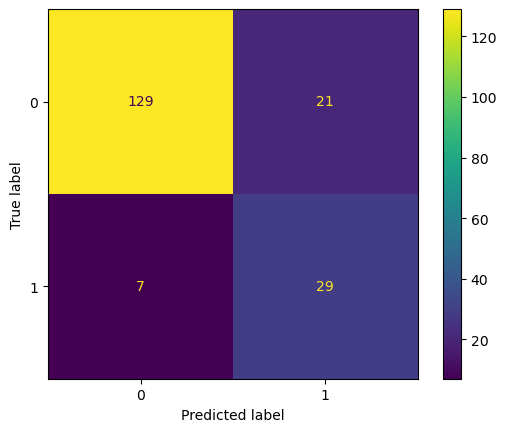

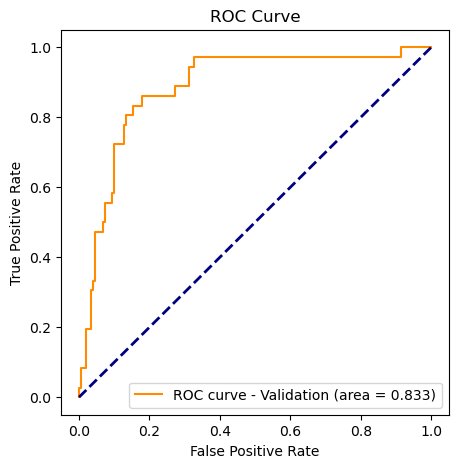

In [44]:
model_performance(xg_pred_test, xg_proba_test, y_test, 'XGBoost')

# Use the roc_auc measure as a weighting to the meta classification decision
xg_roc_auc = metrics.roc_auc_score(y_test, xg_pred_test, labels=['0','1'])

In [45]:
# model_performance(lgbm_pred_test, lgbm_proba_test, y_test, 'LGBM')

# # Use the roc_auc measure as a weighting to the meta classification decision
# lgbm_roc_auc = metrics.roc_auc_score(y_test, lgbm_pred_test, labels=['0','1'])

Scoring Metrics for Logistic Regression (Validation)
Balanced Accuracy Score = 0.814
Accuracy Score = 0.871
Precision Score = 0.650
F1 Score = 0.684
Recall Score = 0.722
ROC AUC Score = 0.814
Confusion Matrix
[[136  14]
 [ 10  26]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       150
           1       0.65      0.72      0.68        36

    accuracy                           0.87       186
   macro avg       0.79      0.81      0.80       186
weighted avg       0.88      0.87      0.87       186

======= ROC Curve =======


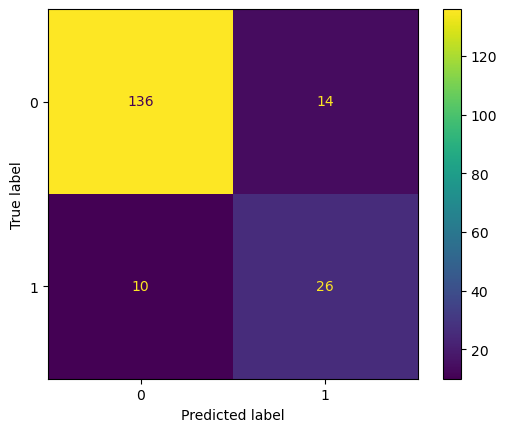

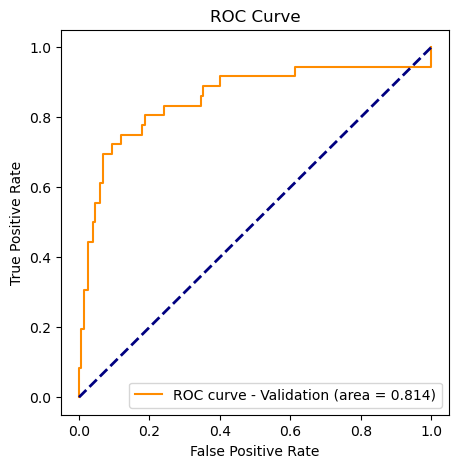

In [46]:
model_performance(logreg_pred_test, logreg_proba_test, y_test, 'Logistic Regression')

# Use the roc_auc measure as a weighting to the meta classification decision
logreg_roc_auc = metrics.roc_auc_score(y_test, logreg_pred_test, labels=['0','1'])

Scoring Metrics for CatBoost (Validation)
Balanced Accuracy Score = 0.876
Accuracy Score = 0.919
Precision Score = 0.784
F1 Score = 0.795
Recall Score = 0.806
ROC AUC Score = 0.876
Confusion Matrix
[[142   8]
 [  7  29]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       150
           1       0.78      0.81      0.79        36

    accuracy                           0.92       186
   macro avg       0.87      0.88      0.87       186
weighted avg       0.92      0.92      0.92       186

======= ROC Curve =======


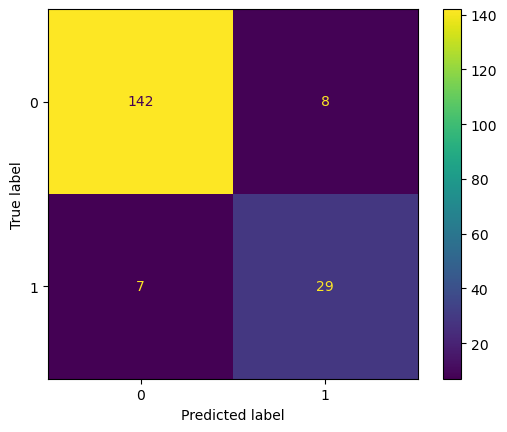

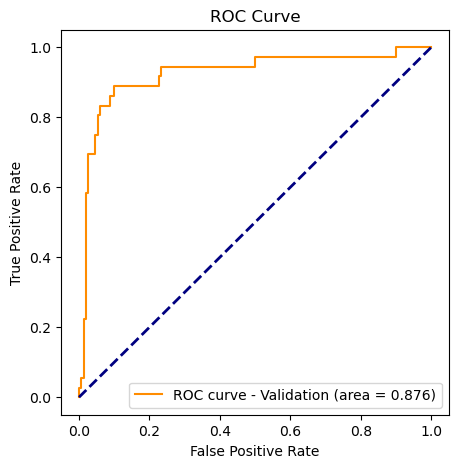

In [47]:
model_performance(cat_pred_test, cat_proba_test, y_test, 'CatBoost')

# Use the roc_auc measure as a weighting to the meta classification decision
cat_roc_auc = metrics.roc_auc_score(y_test, cat_pred_test, labels=['0','1'])

# 5.1. Model Explanation

In [48]:
def model_explanation (model_name, name):

    # Explain the Global Importance
    importances = model_name.feature_importances_

    # Get the indices of the top 20 features.
    top_indices = importances.argsort()[::-1][:20]

    # Get the names of the top 20 features.
    top_feature_names = X_smote.columns[top_indices]

    # Get the importances of the top 20 features.
    top_importances = importances[top_indices]

    # Plot the feature importances for the top 20 features.
    plt.figure(figsize = (10, 6))
    plt.bar(range(len(top_feature_names)), top_importances)
    plt.xticks(range(len(top_feature_names)), top_feature_names, rotation = 90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Top 20 Feature Importance - ' + name)
    plt.tight_layout()
    plt.show()

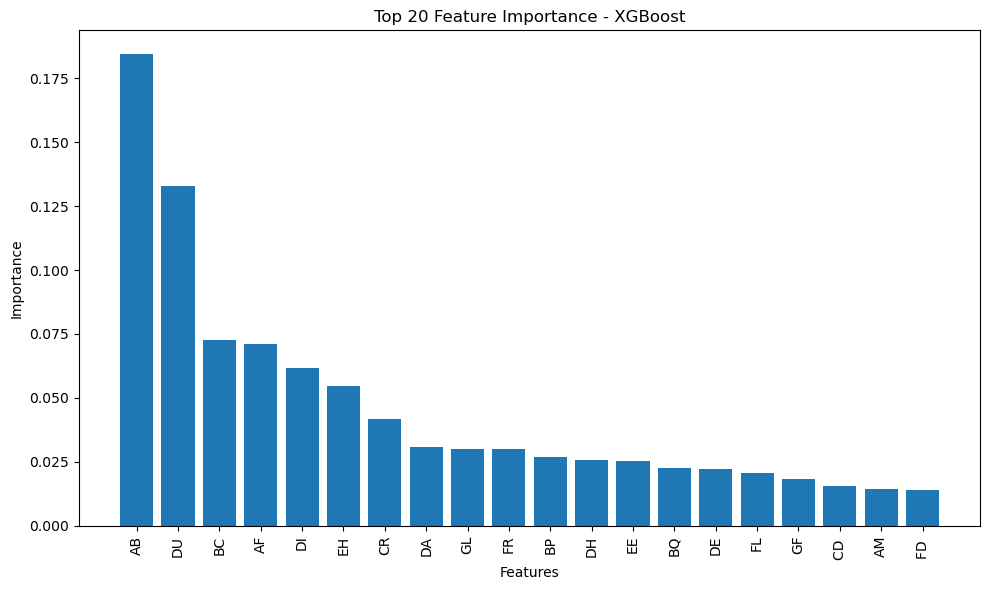

In [49]:
# Global Importance for XGBoost
model_explanation(best_xgb, 'XGBoost')

In [50]:
# # Global Importance for LGBM
# model_explanation(best_lgbm, 'LGBM')

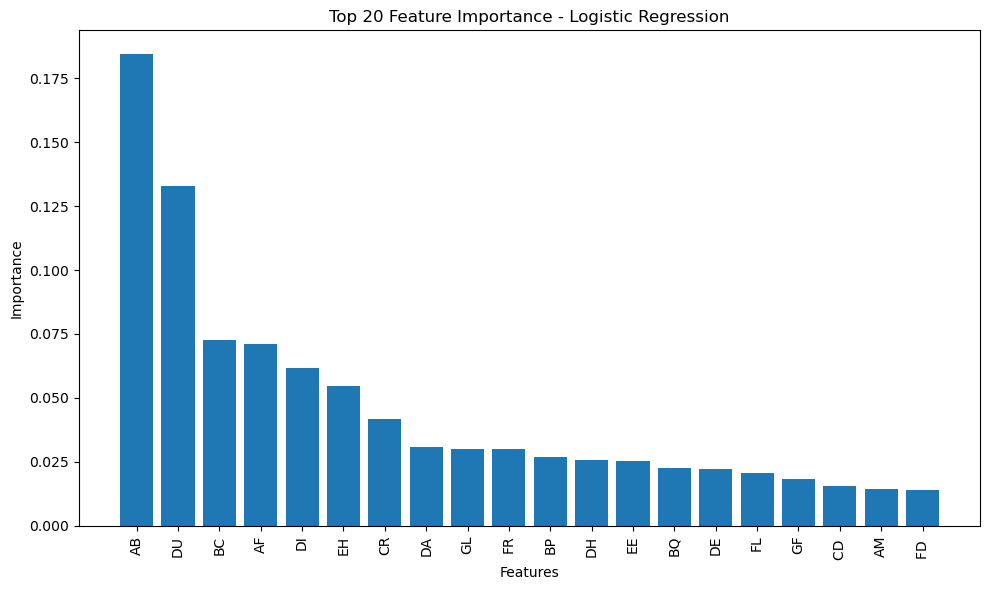

In [51]:
# Global Importance for Logistic Regression
model_explanation(best_xgb, 'Logistic Regression')

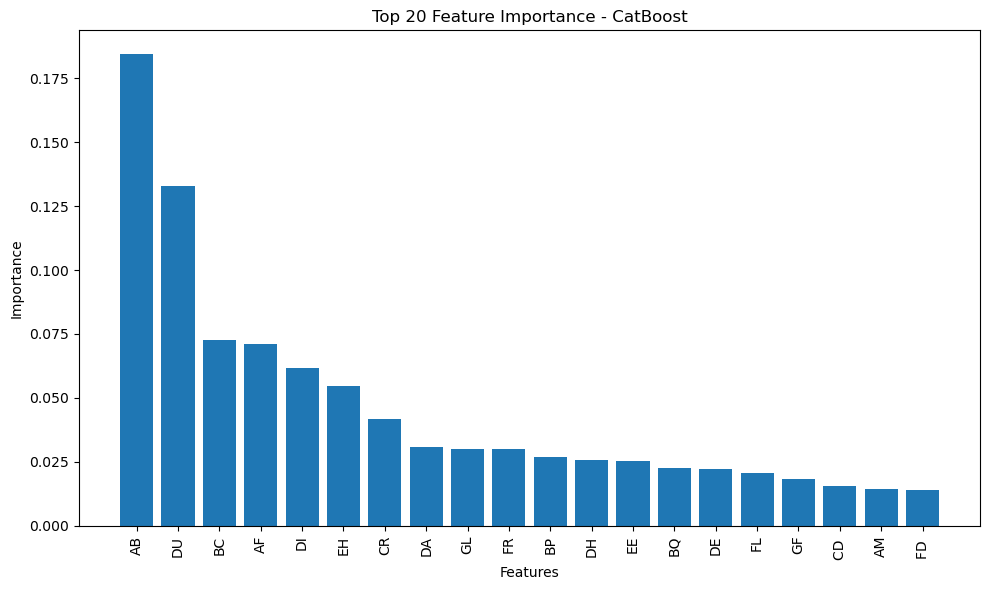

In [52]:
# Global Importance for XGBoost
model_explanation(best_xgb, 'CatBoost')

# 6. Prediction and Submission

In [53]:
# Use the roc_auc as weighting in the meta classification

# prediction probability of XGBoost
xg_pred = xg_model.predict_proba(df_test_2.drop(['Id'], axis=1))
print('========== XGBoost ==========')
print(xg_pred)

# # prediction probability of LGBM
# lgbm_pred = lgbm_model.predict_proba(df_test_2.drop(['Id'], axis=1))
# print('========== LGBM ==========')
# print(lgbm_pred)

# prediction probability of Logistic Regression
logreg_pred = logreg_model.predict_proba(df_test_2.drop(['Id'], axis=1))
print('========== Logistic Regression ==========')
print(logreg_pred)

# prediction probability of CatBoost 
cat_pred = cat_model.predict_proba(df_test_2.drop(['Id'], axis=1))
print('========== CatBoost ==========')
print(logreg_pred)


========== XGBoost ==========
[[0.73667693 0.26332307]
 [0.73667693 0.26332307]
 [0.73667693 0.26332307]
 [0.73667693 0.26332307]
 [0.73667693 0.26332307]]
========== Logistic Regression ==========
[[0.07703849 0.92296151]
 [0.07703849 0.92296151]
 [0.07703849 0.92296151]
 [0.07703849 0.92296151]
 [0.07703849 0.92296151]]
========== CatBoost ==========
[[0.07703849 0.92296151]
 [0.07703849 0.92296151]
 [0.07703849 0.92296151]
 [0.07703849 0.92296151]
 [0.07703849 0.92296151]]


In [55]:
# weight of XGBoost
xg_weight = xg_roc_auc/(xg_roc_auc + logreg_roc_auc + cat_roc_auc)
# lgbm_weight = lgbm_roc_auc/(lgbm_roc_auc + xg_roc_auc + logreg_roc_auc)
logreg_weight = logreg_roc_auc/(xg_roc_auc + logreg_roc_auc + cat_roc_auc)
cat_weight = cat_roc_auc/(xg_roc_auc + logreg_roc_auc + cat_roc_auc)

print('Weight of XGBoost : {}, Weight of Reg : {}, Weight of Cat : {}'.format(xg_weight, logreg_weight, cat_weight))


Weight of XGBoost : 0.33003082342580364, Weight of Reg : 0.3227653016292382, Weight of Cat : 0.34720387494495814


In [57]:
submission = df_test_2[['Id']].copy()
submission['Class_0'] = (xg_pred[:,0] * xg_weight) + (logreg_pred[:,0] * logreg_weight) + (cat_pred[:,0] * cat_weight)
submission['Class_1'] = (xg_pred[:,1] * xg_weight) + (logreg_pred[:,1] * logreg_weight) + (cat_pred[:,1] * cat_weight)
submission.to_csv('submission.csv',index=False)
submission.head()

,Id,Class_0,Class_1
0,00eed32682bb,0.613539,0.386461
1,010ebe33f668,0.613539,0.386461
2,02fa521e1838,0.613539,0.386461
3,040e15f562a2,0.613539,0.386461
4,046e85c7cc7f,0.613539,0.386461
